# _Warm Gradient Descent_

### To do list:
- multiple feature
- polynomial dataset
- logistic classification
- ...

## Preparations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
%matplotlib inline

In [2]:
np.random.seed(42)

In [3]:
os.makedirs("./images", exist_ok=True)

In [4]:
# In order to save figures

def save_fig(fig_id, resolution=300):
    path = os.path.join("./images", fig_id + ".png")
    print("Saving figure", fig_id)
    plt.savefig(path, format="png", dpi=resolution)

In [5]:
# Creating the data
# We will generate linear data with some normally distributed noise

m = 100 # size of the dataset

X = 2* np.random.rand(m,1)
y = 4 + 3 * X + np.random.randn(m,1)

Saving figure generated_data_plot


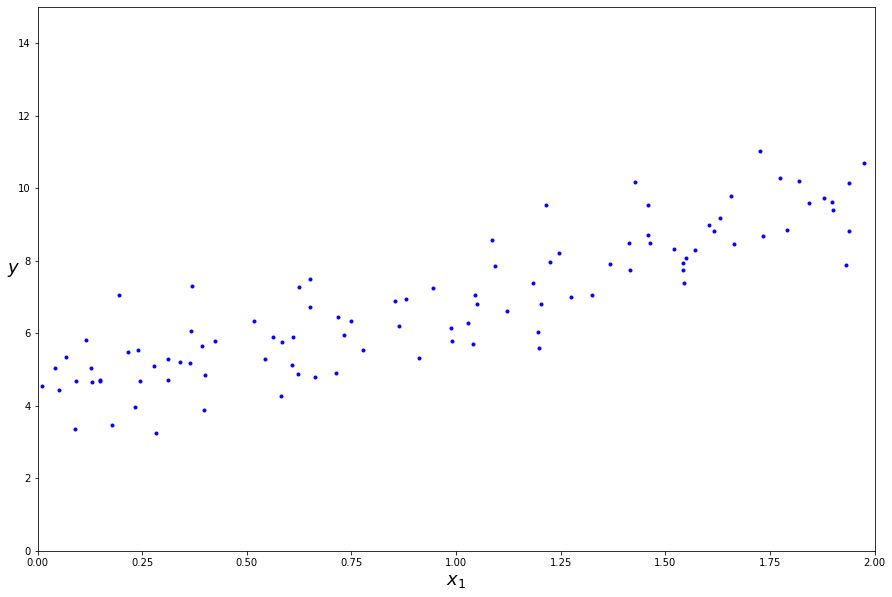

In [6]:
# Plotting the created data

plt.figure(figsize=(15,10))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [7]:
# Adding the bias term to the data

X_b = np.c_[np.ones((m, 1)), X]

In [8]:
# Creating new data to check predictions

X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]

## Scikit-learn's linear regression class

In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [10]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

## Batch gradient descent

In [11]:
theta_path_bgd = []
eta = 0.1
n_iterations = 1000

theta = np.random.randn(2,1) # Random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    theta_path_bgd.append(theta)
    
theta_path_bgd = np.array(theta_path_bgd)

In [12]:
theta

array([[4.21509616],
       [2.77011339]])

In [13]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

## Stochastic gradient descent

In [14]:
np.random.seed(42)

In [15]:
theta_path_sgd = []
n_epochs = 40
t0, t1 = 5, 50 #learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t+t1)

theta = np.random.randn(2,1) #random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta)-yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta*gradients
        theta_path_sgd.append(theta)
        
theta_path_sgd = np.array(theta_path_sgd)

In [16]:
theta

array([[4.22956212],
       [2.73395403]])

In [17]:
X_new_b.dot(theta)

array([[4.22956212],
       [9.69747017]])

## Mini-batch gradient descent

In [18]:
theta_path_mgd = []

m = 100 #size of the dataset
n_epochs =  40
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1) #random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t+t1)

t = 0
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1 
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta)-yi)
        eta = learning_schedule(t)
        theta = theta - eta*gradients
        theta_path_mgd.append(theta)
        
theta_path_mgd = np.array(theta_path_mgd)

In [19]:
theta

array([[4.2695937 ],
       [2.84744074]])

In [20]:
X_new_b.dot(theta)

array([[4.2695937 ],
       [9.96447518]])

Saving figure gradient_descent_paths_plot


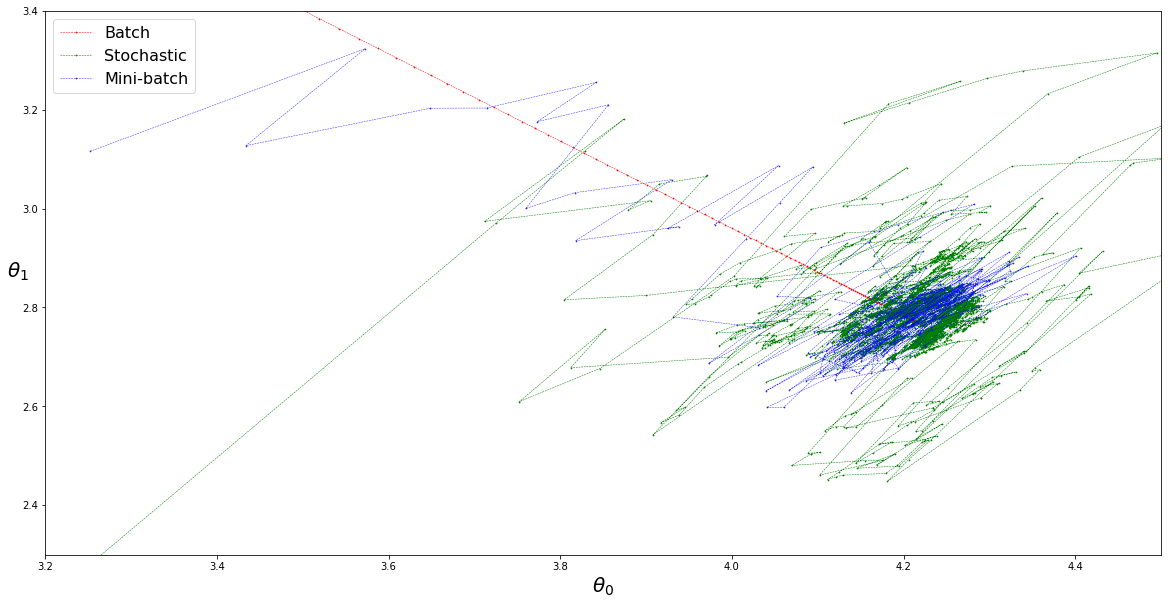

In [21]:
plt.figure(figsize=(20,10))
plt.plot(theta_path_bgd[:,0], theta_path_bgd[:,1], "r--o", linewidth=0.5, label="Batch", markersize=0.7)
plt.plot(theta_path_sgd[:,0], theta_path_sgd[:,1], "g--o", linewidth=0.5, label="Stochastic", markersize=0.7)
plt.plot(theta_path_mgd[:,0], theta_path_mgd[:,1], "b--o", linewidth=0.5, label="Mini-batch", markersize=0.7, alpha=0.8)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$", fontsize=20, rotation=0)
plt.axis([3.2, 4.5, 2.3, 3.4])
save_fig("gradient_descent_paths_plot")
plt.show()

## Warm Gradient Descent

### One feature, linear dataset, varying learning rate $\eta$, piecewise linear function

We want to generalize the mini-batch gradient descent in two compatible directions:
- the size of the mini-batch should be a function of the epoch 
- whenever the data is characterized by multiple features, one should choose randomly at each training step a subset of the features and update the gradient only along these features direction
    

In [22]:
import math

In [23]:
theta_path_wgd = []

m = 100 # size of the dataset
n_epochs =  50 # number of times one goes through the whole dataset

np.random.seed(42)
theta = np.random.randn(2,1) #random initialization

t = 0
t0, t1 = 200, 1000    # these are hyperparameters entering in the learning_schedule
def learning_schedule(t):
    return t0 / (t+t1)

ns = 30    # this is a hyperparameter entering in the temperature profile function, 1 <= ns <= n_epochs
def temperature_profile(epoch):
    if epoch < ns:
        return math.floor((-(m-1)*epoch + m*ns -1) / (ns - 1))
    else:
        return math.floor(((m-1)*epoch + n_epochs - m*ns) / (n_epochs - ns))
    
    #return m
    
    #return 1
        
for epoch in range(n_epochs):
    
    minibatch_size = temperature_profile(epoch)
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    
    for i in range(0, m, minibatch_size):
        t += 1 
        eta = learning_schedule(t) 
        
        if (i+minibatch_size) <= m:                    # to check if we don't exceed the size of the dataset
            xi = X_b_shuffled[i:i+minibatch_size]
            yi = y_shuffled[i:i+minibatch_size]
            gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta)-yi)
            
        else:
            xi = X_b_shuffled[i:-1]
            yi = y_shuffled[i:-1]
            gradients = 2/(m-i) * xi.T.dot(xi.dot(theta)-yi)
            
        theta = theta - eta*gradients
        theta_path_wgd.append(theta)
        
theta_path_wgd = np.array(theta_path_wgd)

In [24]:
theta

array([[4.28527088],
       [2.83170984]])

In [25]:
X_new_b.dot(theta)

array([[4.28527088],
       [9.94869056]])

Saving figure gradient_descent_paths_plot_2


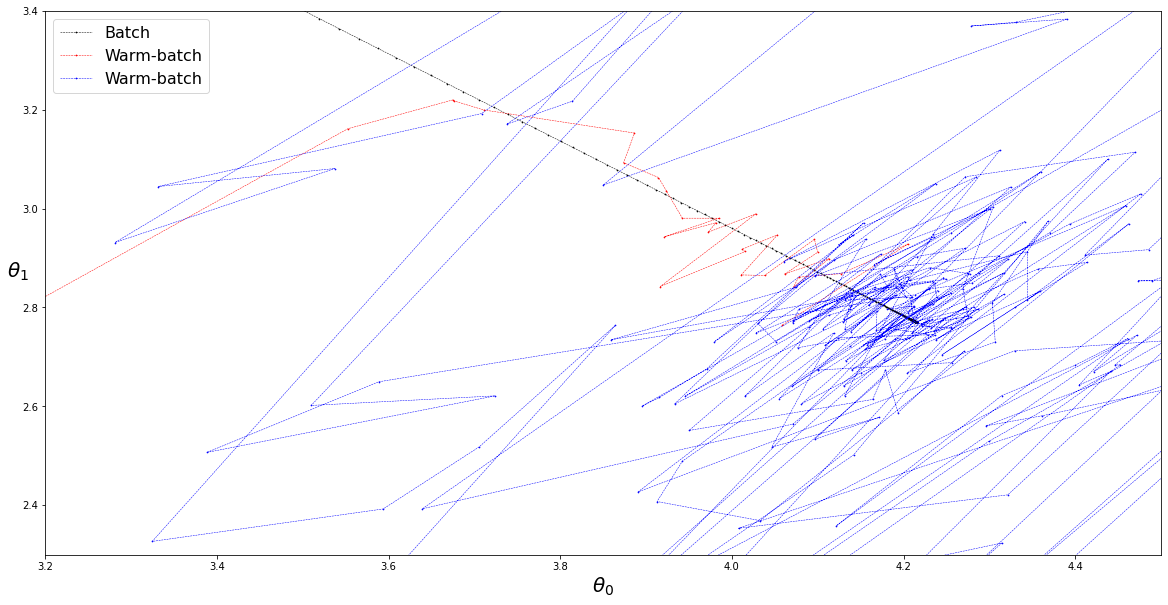

In [26]:
plt.figure(figsize=(20,10))
plt.plot(theta_path_bgd[:,0], theta_path_bgd[:,1], "k--o", linewidth=0.5, label="Batch", markersize=0.7)
#plt.plot(theta_path_sgd[:,0], theta_path_sgd[:,1], "g--o", linewidth=0.5, label="Stochastic", markersize=0.7)
#plt.plot(theta_path_mgd[:,0], theta_path_mgd[:,1], "b--o", linewidth=0.5, label="Mini-batch", markersize=0.7, alpha=0.8)
plt.plot(theta_path_wgd[:ns,0], theta_path_wgd[:ns,1], "r--o", linewidth=0.5, label="Warm-batch", markersize=0.7)
plt.plot(theta_path_wgd[ns:-1,0], theta_path_wgd[ns:-1,1], "b--o", linewidth=0.5, label="Warm-batch", markersize=0.7)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$", fontsize=20, rotation=0)
plt.axis([3.2, 4.5, 2.3, 3.4])
save_fig("gradient_descent_paths_plot_2")
plt.show()

Saving figure temperature_profile_1


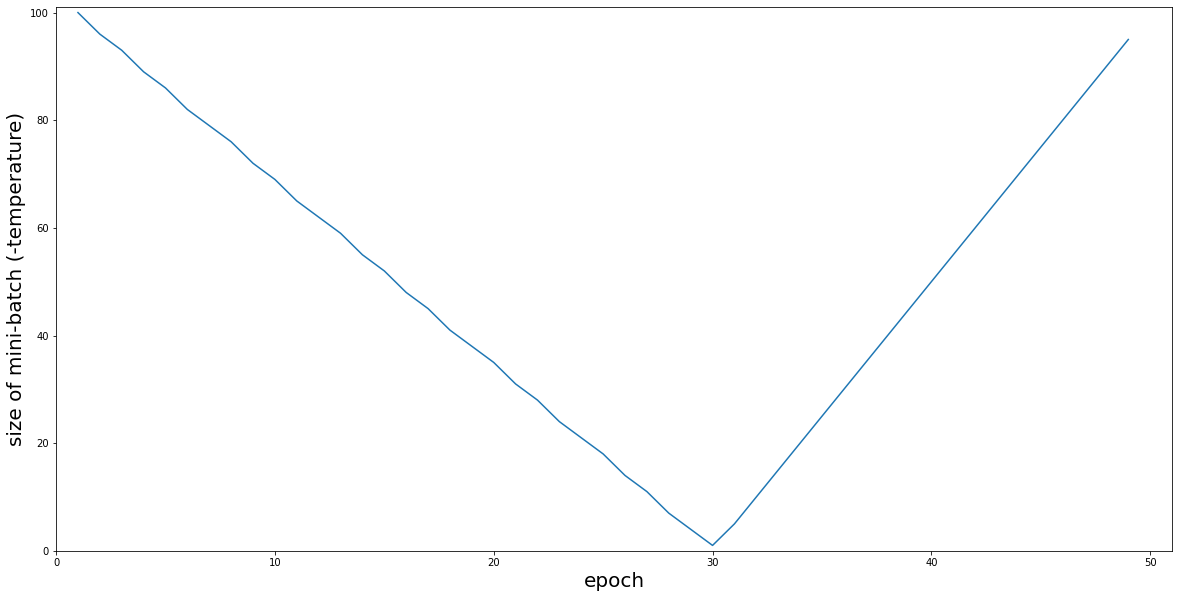

In [27]:
# This is the first function I defined

m = 100 # size of the dataset
n_epochs =  50 # number of times one goes through the whole dataset
ns = 30    # this is a hyperparameter entering in the temperature profile function, 1 <= ns <= n_epochs
def temperature_profile(epoch):
    if epoch < ns:
        return math.floor((-(m-1)*epoch + m*ns -1) / (ns - 1))
    else:
        return math.floor(((m-1)*epoch + n_epochs - m*ns) / (n_epochs - ns))

x = np.arange(1,n_epochs)
t = np.array([temperature_profile(i) for i in x])

plt.figure(figsize=(20,10))
plt.plot(x, t)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("size of mini-batch (-temperature)", fontsize=20, rotation=90)
plt.axis([0.0, 51.0, 0.0, 101.0])
save_fig("temperature_profile_1")
plt.show()

Saving figure temperature_profile_2


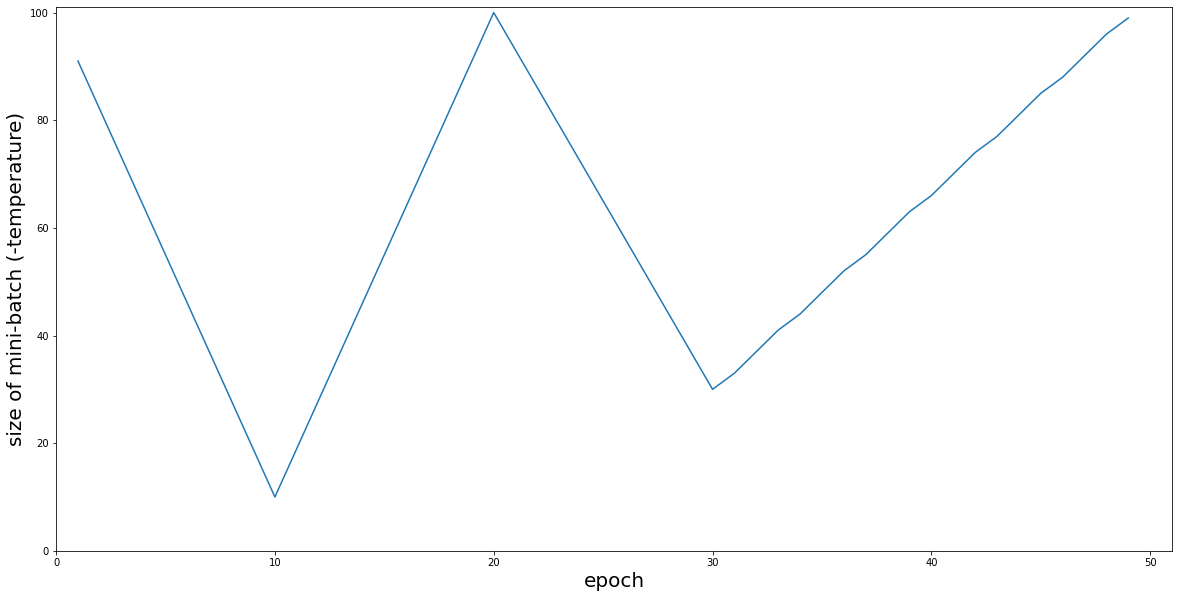

In [28]:
# This is a generalization of the previous function

m = 100 # size of the dataset
n_epochs =  50 # number of times one goes through the whole dataset


ns = [0,10, 20, 30,n_epochs-1]  # this is a hyperparameter entering in the temperature profile function
ts = [100, 10, 100, 30, 100]
def temperature_profile(epoch):  # this is a piecewise linear function interpolation between the points (ns[i],ts[i])
    for i in range(len(ns)):
        if ns[i] <= epoch and epoch <= ns[i+1]:
            return math.floor(((ts[i+1]-ts[i])/(ns[i+1]-ns[i])) * epoch + (ts[i]*ns[i+1]-ts[i+1]*ns[i])/(ns[i+1]-ns[i]))
    

x = np.arange(1,n_epochs)
t = np.array([temperature_profile(i) for i in x])

plt.figure(figsize=(20,10))
plt.plot(x, t)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("size of mini-batch (-temperature)", fontsize=20, rotation=90)
plt.axis([0.0, 51.0, 0.0, 101.0])
save_fig("temperature_profile_2")
plt.show()

Let us try this more generic piecewise linear function in the gradient descent

In [29]:
temperature_profile(49)

99

In [30]:
theta_path_wgd = []

m = 100 # size of the dataset
n_epochs =  50 # number of times one goes through the whole dataset

np.random.seed(42)
theta = np.random.randn(2,1) #random initialization

t = 0
t0, t1 = 200, 1000    # these are hyperparameters entering in the learning_schedule
def learning_schedule(t):
    return t0 / (t+t1)

ns = [0,10, 20, 30,n_epochs-1]  # this is a hyperparameter entering in the temperature profile function
ts = [100, 10, 100, 30, 100]
def temperature_profile(epoch):  # this is a piecewise linear function interpolation between the points (ns[i],ts[i])
    for i in range(len(ns)):
        if ns[i] <= epoch and epoch <= ns[i+1]:
            return math.floor(((ts[i+1]-ts[i])/(ns[i+1]-ns[i])) * epoch + (ts[i]*ns[i+1]-ts[i+1]*ns[i])/(ns[i+1]-ns[i]))
        
for epoch in range(n_epochs):
    
    minibatch_size = temperature_profile(epoch)
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    
    for i in range(0, m, minibatch_size):
        t += 1 
        eta = learning_schedule(t) 
        
        if (i+minibatch_size) <= m:                    # to check if we don't exceed the size of the dataset
            xi = X_b_shuffled[i:i+minibatch_size]
            yi = y_shuffled[i:i+minibatch_size]
            gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta)-yi)
            
        else:
            xi = X_b_shuffled[i:-1]
            yi = y_shuffled[i:-1]
            gradients = 2/(m-i) * xi.T.dot(xi.dot(theta)-yi)
            
        theta = theta - eta*gradients
        theta_path_wgd.append(theta)
        
theta_path_wgd = np.array(theta_path_wgd)

In [31]:
theta

array([[4.27932336],
       [2.70352259]])

Saving figure gradient_descent_paths_plot_3


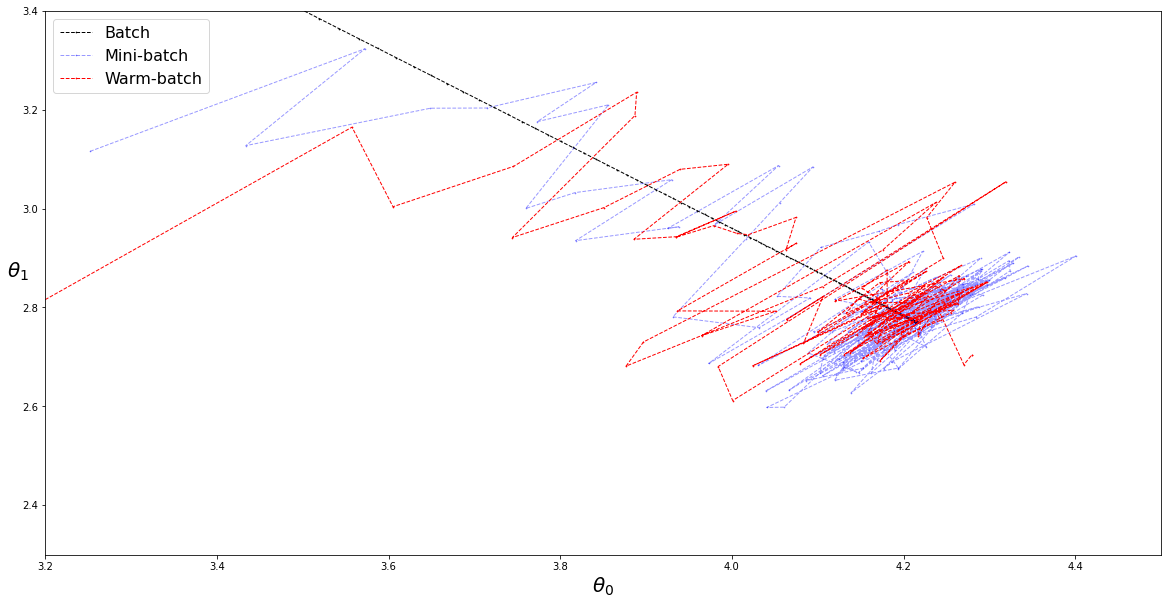

In [32]:
plt.figure(figsize=(20,10))
plt.plot(theta_path_bgd[:,0], theta_path_bgd[:,1], "k--o", linewidth=1.0, label="Batch", markersize=0.7)
#plt.plot(theta_path_sgd[:,0], theta_path_sgd[:,1], "g--o", linewidth=0.5, label="Stochastic", markersize=0.7)
plt.plot(theta_path_mgd[:,0], theta_path_mgd[:,1], "b--o", linewidth=1.0, label="Mini-batch", markersize=0.7, alpha=0.4)
plt.plot(theta_path_wgd[:,0], theta_path_wgd[:,1], "r--o", linewidth=1.0, label="Warm-batch", markersize=0.7)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$", fontsize=20, rotation=0)
plt.axis([3.2, 4.5, 2.3, 3.4])
save_fig("gradient_descent_paths_plot_3")
plt.show()

### Linear data, one feature, constant learning rate $\eta$ to isolate the effect of the varying mini-batch temperature

#### Piecewise linear temperature

In [33]:
# This is the piecewise linear temperature function

m = 100 # size of the dataset
n_epochs =  50 # number of times one goes through the whole dataset

ns = [0,10, 20, 30,n_epochs-1]  # this is a hyperparameter entering in the temperature profile function
ts = [100, 10, 100, 30, 100]
def temperature_profile(epoch):  # this is a piecewise linear function interpolation between the points (ns[i],ts[i])
    for i in range(len(ns)):
        if ns[i] <= epoch and epoch <= ns[i+1]:
            return math.floor(((ts[i+1]-ts[i])/(ns[i+1]-ns[i])) * epoch + (ts[i]*ns[i+1]-ts[i+1]*ns[i])/(ns[i+1]-ns[i]))

In [34]:
theta_path_wgd = []   # For the plot

m = 100 # size of the dataset
n_epochs =  50 # number of times one goes through the whole dataset

np.random.seed(42)
theta = np.random.randn(2,1) #random initialization

for epoch in range(n_epochs):
    
    minibatch_size = temperature_profile(epoch)
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    eta = 0.1
    
    for i in range(0, m, minibatch_size): 
        
        if (i+minibatch_size) <= m:                    # to check if we don't exceed the size of the dataset
            xi = X_b_shuffled[i:i+minibatch_size]
            yi = y_shuffled[i:i+minibatch_size]
            gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta)-yi)
            
        else:
            xi = X_b_shuffled[i:-1]
            yi = y_shuffled[i:-1]
            gradients = 2/(m-i) * xi.T.dot(xi.dot(theta)-yi)
            
        theta = theta - eta*gradients
        
        theta_path_wgd.append(theta)   # For the plot
        
theta_path_wgd = np.array(theta_path_wgd)  # For the plot

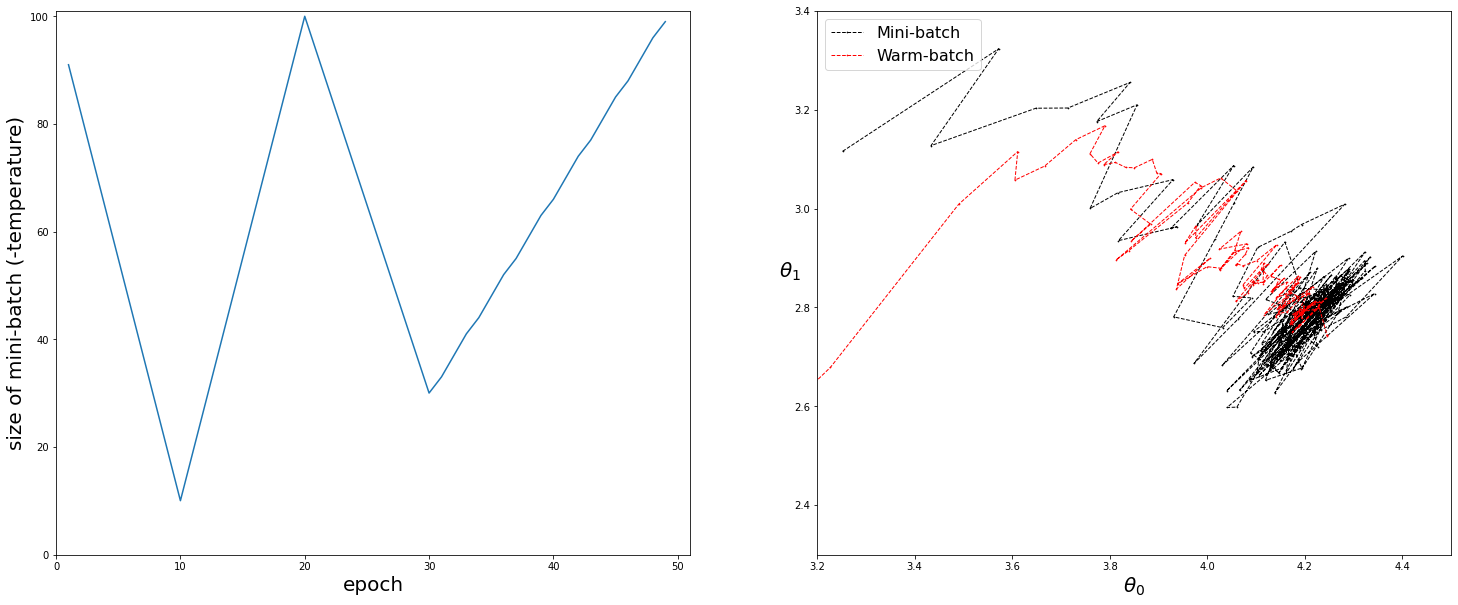

In [35]:
x = np.arange(1,n_epochs)
T = np.array([temperature_profile(i) for i in x])

plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(x, T)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("size of mini-batch (-temperature)", fontsize=20, rotation=90)
plt.axis([0.0, 51.0, 0.0, 101.0])
plt.subplot(1,2,2)
plt.plot(theta_path_mgd[:,0], theta_path_mgd[:,1], "k--o", linewidth=1.0, label="Mini-batch", markersize=0.7)
plt.plot(theta_path_wgd[:,0], theta_path_wgd[:,1], "r--o", linewidth=1.0, label="Warm-batch", markersize=0.7)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$", fontsize=20, rotation=0)
plt.axis([3.2, 4.5, 2.3, 3.4])
plt.show()

#### |Cos|*Exp temperature

Saving figure temperature_profile_2


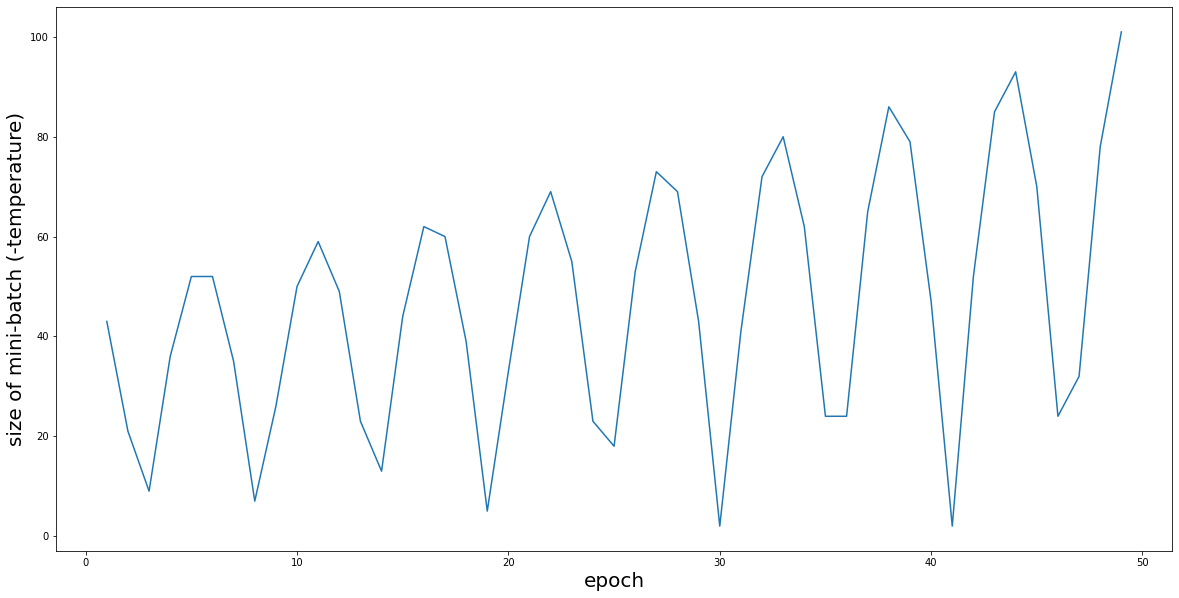

In [36]:
# This is the piecewise linear temperature function

m = 100 # size of the dataset
n_epochs =  50 # number of times one goes through the whole dataset

mu = 10.  # This is a hyperparameter in the following cosine with exponential envelope temperature profile
n0 = 50
def temperature_profile(epoch):  # this is a piecewise linear function interpolation between the points (ns[i],ts[i])
    return int(np.ceil(n0*np.abs(np.cos(mu*epoch)*np.exp(epoch * (np.log(m)-np.log(n0*np.cos(mu*(n_epochs-1)))) / (n_epochs-1)))))
    
x = np.arange(1,n_epochs)
t = np.array([temperature_profile(i) for i in x])

plt.figure(figsize=(20,10))
plt.plot(x, t)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("size of mini-batch (-temperature)", fontsize=20, rotation=90)
#plt.axis([0.0, 51.0, 0.0, 101.0])
save_fig("temperature_profile_2")
plt.show()

In [37]:
temperature_profile(2)

21

In [38]:
theta_path_wgd = []   # For the plot

m = 100 # size of the dataset
n_epochs =  50 # number of times one goes through the whole dataset

np.random.seed(42)
theta = np.random.randn(2,1) #random initialization

for epoch in range(n_epochs):
    
    minibatch_size = temperature_profile(epoch)
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    eta = 0.1
    
    for i in range(0, m, minibatch_size): 
        
        if (i+minibatch_size) <= m:                    # to check if we don't exceed the size of the dataset
            xi = X_b_shuffled[i:i+minibatch_size]
            yi = y_shuffled[i:i+minibatch_size]
            gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta)-yi)
            
        else:
            xi = X_b_shuffled[i:-1]
            yi = y_shuffled[i:-1]
            gradients = 2/(m-i) * xi.T.dot(xi.dot(theta)-yi)
            
        theta = theta - eta*gradients
        
        theta_path_wgd.append(theta)   # For the plot
        
theta_path_wgd = np.array(theta_path_wgd)  # For the plot

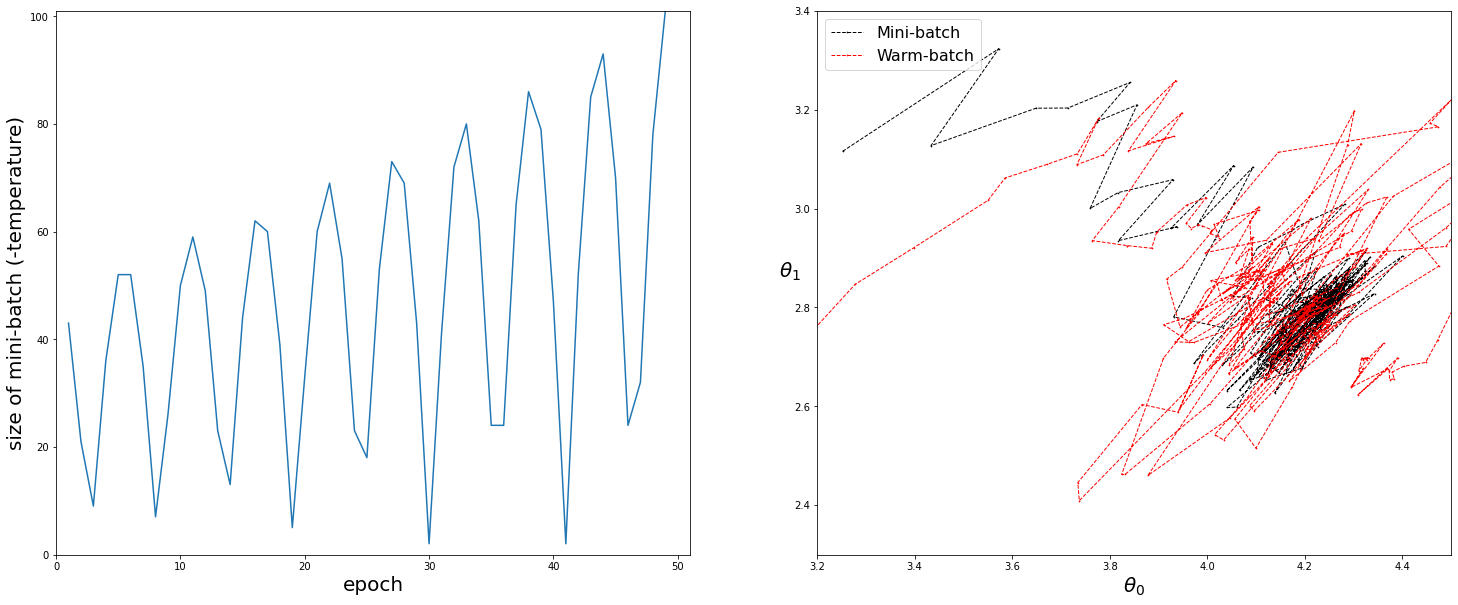

In [39]:
x = np.arange(1,n_epochs)
T = np.array([temperature_profile(i) for i in x])

plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(x, T)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("size of mini-batch (-temperature)", fontsize=20, rotation=90)
plt.axis([0.0, 51.0, 0.0, 101.0])
plt.subplot(1,2,2)
plt.plot(theta_path_mgd[:,0], theta_path_mgd[:,1], "k--o", linewidth=1.0, label="Mini-batch", markersize=0.7)
plt.plot(theta_path_wgd[:,0], theta_path_wgd[:,1], "r--o", linewidth=1.0, label="Warm-batch", markersize=0.7)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$", fontsize=20, rotation=0)
plt.axis([3.2, 4.5, 2.3, 3.4])
plt.show()

In [40]:
theta

array([[4.31495825],
       [2.69468002]])

### Cos^2 * exp temperature profile

In [58]:
theta_path_wgd = []   # For the plot

m = 100 # size of the dataset
n_epochs =  50 # number of times one goes through the whole dataset


p = 3  # This is a hyperparameter in the following cosine with exponential envelope temperature profile, it must be a non-negative integer
n0 = 5 # This is a hyperparameter fixing the initial mini-batch size
def temperature_profile(epoch):  # this is a piecewise linear function interpolation between the points (ns[i],ts[i])
    return int(np.ceil(n0 * np.cos(2*p*np.pi*epoch / (n_epochs-1))**2 * np.exp(epoch * np.log(m/(n0*np.cos(2*p*np.pi)**2)) / (n_epochs-1))))


np.random.seed(42)
theta = np.random.randn(2,1) #random initialization

for epoch in range(n_epochs):
    
    minibatch_size = temperature_profile(epoch)
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    eta = 0.01
    
    for i in range(0, m, minibatch_size): 
        
        if (i+minibatch_size) <= m:                    # to check if we don't exceed the size of the dataset
            xi = X_b_shuffled[i:i+minibatch_size]
            yi = y_shuffled[i:i+minibatch_size]
            gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta)-yi)
            
        else:
            xi = X_b_shuffled[i:-1]
            yi = y_shuffled[i:-1]
            gradients = 2/(m-i) * xi.T.dot(xi.dot(theta)-yi)
            
        theta = theta - eta*gradients
        
        theta_path_wgd.append(theta)   # For the plot
        
theta_path_wgd = np.array(theta_path_wgd)  # For the plot

Saving figure temperature_profile_3


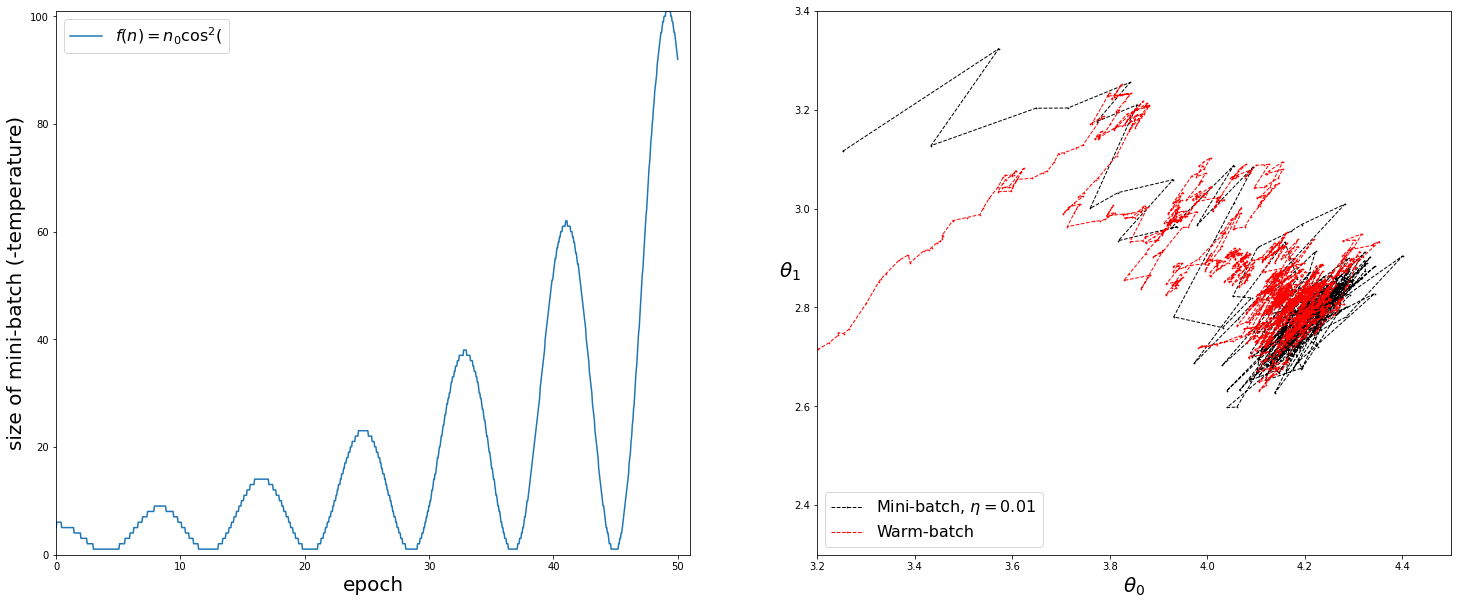

In [66]:
x = np.linspace(0,n_epochs,1000)
T = np.array([temperature_profile(i) for i in x])

plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(x, T, label="$f(n)=n_0 \cos^2(\frac{2p\pi}{n_\text{epochs}-1}\,n)\exp(b n)$")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("size of mini-batch (-temperature)", fontsize=20, rotation=90)
plt.axis([0.0, 51.0, 0.0, 101.0])
plt.subplot(1,2,2)
plt.plot(theta_path_mgd[:,0], theta_path_mgd[:,1], "k--o", linewidth=1.0, label=r"Mini-batch, $\eta=0.01$", markersize=0.7)
plt.plot(theta_path_wgd[:,0], theta_path_wgd[:,1], "r--o", linewidth=1.0, label="Warm-batch", markersize=0.7)
plt.legend(loc="lower left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$", fontsize=20, rotation=0)
plt.axis([3.2, 4.5, 2.3, 3.4])
save_fig("temperature_profile_3")
plt.show()

In [67]:
theta

array([[4.16375651],
       [2.69507016]])